In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os

!pip install pytorch-fid

In [ ]:
# Hyperparameters
image_size = 32
batch_size = 128
latent_dim = 100
num_epochs = 30  # set this to your desired final epoch
learning_rate = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
os.makedirs("generated_images", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.main(x).view(-1)

# Models
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Training loop
for epoch in range(start_epoch, num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size_curr, device=device)
        fake_labels = torch.zeros(batch_size_curr, device=device)

        # Train discriminator
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        noise = torch.randn(batch_size_curr, latent_dim, 1, 1, device=device)
        fake_images = G(noise)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        D.zero_grad()
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train generator
        G.zero_grad()
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizerG.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                  f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

    # Save images for each epoch
    with torch.no_grad():
        fake_images = G(fixed_noise).detach().cpu()
    vutils.save_image(fake_images, f"generated_images/epoch_{epoch+1}.png", normalize=True, nrow=8)

print("Training complete.")


Epoch [1/30], Step [100/391], D_loss: 0.0059, G_loss: 9.6730
Epoch [1/30], Step [200/391], D_loss: 0.6015, G_loss: 2.7415
Epoch [1/30], Step [300/391], D_loss: 0.5880, G_loss: 3.1000
Epoch [2/30], Step [100/391], D_loss: 0.5253, G_loss: 2.3682
Epoch [2/30], Step [200/391], D_loss: 0.4379, G_loss: 3.1115
Epoch [2/30], Step [300/391], D_loss: 1.1557, G_loss: 4.7855
Epoch [3/30], Step [100/391], D_loss: 0.6010, G_loss: 1.7894
Epoch [3/30], Step [200/391], D_loss: 0.3813, G_loss: 2.9950
Epoch [3/30], Step [300/391], D_loss: 0.7482, G_loss: 3.8685
Epoch [4/30], Step [100/391], D_loss: 0.3903, G_loss: 2.6114
Epoch [4/30], Step [200/391], D_loss: 0.7306, G_loss: 3.4138
Epoch [4/30], Step [300/391], D_loss: 0.2983, G_loss: 3.3351
Epoch [5/30], Step [100/391], D_loss: 0.3638, G_loss: 2.8833
Epoch [5/30], Step [200/391], D_loss: 0.2554, G_loss: 3.8217
Epoch [5/30], Step [300/391], D_loss: 0.2843, G_loss: 2.7387
Epoch [6/30], Step [100/391], D_loss: 1.0422, G_loss: 2.4360
Epoch [6/30], Step [200/

In [ ]:
# 1. Save grid of generated images
def save_generated_images(Generator, epoch, device, latent_dim=100, out_dir='generated_images'):
    os.makedirs(out_dir, exist_ok=True)
    Generator.eval()
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = Generator(fixed_noise).detach().cpu()
    vutils.save_image(fake_images, f'{out_dir}/dcgan_generated_epoch{epoch}.png', normalize=True, nrow=8)
    Generator.train()

In [ ]:
# 2. Plot loss curves
def plot_gan_losses(g_losses, d_losses, savepath='dcgan_loss_curves.png'):
    plt.figure(figsize=(10,5))
    plt.title("DCGAN Loss During Training")
    plt.plot(g_losses,label="Generator")
    plt.plot(d_losses,label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(savepath)
    plt.close()

In [ ]:
# 3. Generate 5000 samples for FID
def generate_samples_for_fid(Generator, device, latent_dim, num_samples=5000, out_dir='generated_samples'):
    os.makedirs(out_dir, exist_ok=True)
    Generator.eval()
    idx = 0
    with torch.no_grad():
        while idx < num_samples:
            z = torch.randn(64, latent_dim, 1, 1, device=device)
            imgs = Generator(z)
            imgs = (imgs + 1) / 2  # [-1,1] to [0,1]
            for i in range(imgs.size(0)):
                vutils.save_image(imgs[i], f"{out_dir}/fake_{idx+i}.png")
            idx += imgs.size(0)
    Generator.train()

In [ ]:
# Save generated image grid at end of training
save_generated_images(G, epoch='final', device=device, latent_dim=100)

In [ ]:
# Plot loss curves
plot_gan_losses(g_losses, d_losses, savepath='dcgan_loss_curves.png')

NameError: name 'g_losses' is not defined

In [ ]:
# Generate samples for FID
generate_samples_for_fid(G, device, latent_dim=100, num_samples=5000, out_dir='generated_samples')

print("Evaluation complete. Image samples, and FID-ready images saved.")

Evaluation complete. Image samples, and FID-ready images saved.


In [ ]:
print("\nContents of generated_samples directory (showing first 10 files):")
!ls generated_samples | head -n 10


Contents of generated_samples directory (showing first 10 files):
fake_0.png
fake_1000.png
fake_1001.png
fake_1002.png
fake_1003.png
fake_1004.png
fake_1005.png
fake_1006.png
fake_1007.png
fake_1008.png


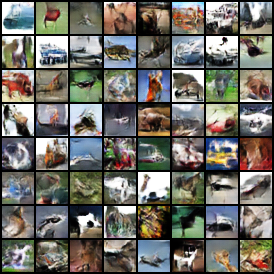

In [ ]:
from IPython.display import Image, display

# Display the final generated image grid
image_path = 'generated_images/dcgan_generated_epochfinal.png'
display(Image(filename=image_path))

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 253, in calculate_fid_given_paths
    raise RuntimeError('Invalid path: %s' % p)
RuntimeError: Invalid path: dcgan_generated_samples
